In [1]:
import os
import sys

sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm, Normalize
from scipy.ndimage import gaussian_filter

from kwave.ktransducer import kWaveGrid
from utils.data import save_mat
from utils.simulations import get_water_SOS

data_path = '../data/'

First, we need to define the size and resolution of the image. In this project, the initial pressure and speed of sound distribution have the same reolsution as the KWave computational grid used in simulations.

In [2]:
Nx, Ny = 560, 560
dx, dy = 4.e-5, 4.e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
x_vec, y_vec = np.meshgrid(kgrid.x_vec.copy(), kgrid.y_vec.copy())

### Initial Pressure

We simulate an image of the initial pressure distribution of mouse liver. We used this [Labeled cross-sectional anatomy of the mouse on micro-CT](https://www.imaios.com/en/vet-anatomy/mouse/mouse-whole-body) as reference.

In [3]:
structures = {
    'body': (9.8e-3, 9.6e-3, 0.7, (0, 0)),
    'tissue': (9.62e-3, 0, 0.02, (0, 0)),
    'liver': (7.5e-3, 7.3e-3, 0.8, (0, 1.7e-3)),
    'vertebral column': (1.35e-3, 1.1e-3, 0.9, (0, -7.7e-3)),
    'abdominal aorta': (0.7e-3, 0.0, 0.8, (0, -5.1e-3)), 
    'stomach lumen': (2.3e-3, 2.1e-3, 0.8, (3e-3, -0.7e-3)),
    'intestine lumen': (1.5e-3, 1.3e-3, 0.8, (-3.6e-3, 3.5e-3)),
    'dot': (0.25e-3, 0, 0.9, (3.5e-3, 1e-3))
}
x_c, y_c = 0, 1.7e-3
x_vec, y_vec = np.meshgrid(kgrid.x_vec.copy(), kgrid.y_vec.copy())
IP = np.ones((Ny, Nx)) * 0.
for key, (R_out, R_in, p, offset) in structures.items():
    if 'dot' in key:
        IP[((x_vec - offset[0])**2 + (y_vec - y_c - offset[1])**2 < R_out**2) & ((x_vec - offset[0])**2 + (y_vec - y_c - offset[1])**2 >= R_in ** 2)] = p
        IP[((x_vec + offset[0])**2 + (y_vec - y_c + offset[1])**2 < R_out**2) & ((x_vec + offset[0])**2 + (y_vec - y_c + offset[1])**2 >= R_in ** 2)] = p
    else:
        IP[((x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R_out**2) & ((x_vec - offset[0])**2 + (y_vec - offset[1])**2 >= R_in ** 2)] = p

# lines
structures = {
    'vessel1': (-6.5e-3, 6.35e-3, -7.3e-3, 5.35e-3, 2.6e-7, 1.0),
    'vessel2': (-4.8e-3, 7.9e-3, -3.7e-3, 8.6e-3, 2.5e-7, 1.0),
    'line1': (-1.1e-3, -1.1e-3, -4.5e-3, -4.5e-3, 2.7e-7, 0.8),
    'line2': (2.e-3, 2.e-3, 2.1e-3, 5e-3, 2.5e-7, 0.8),
    'line3': (3.e-3, 3.e-3, 5.e-3, 3.1e-3, 2.3e-7, 0.8),
    'line4': (3.5e-3, 3.5e-3, 3.2e-3, 5.4e-3, 1.4e-7, 0.8),
    'line5': (3.9e-3, 3e-3, 3.7e-3, 1.8e-3, 0.8e-7, 0.8),
    'line6': (2.1e-3, 4e-3, 0.7e-3, 3.7e-3, 1.e-7, 0.8),
}

for key, (x1, y1, x2, y2, w, p) in structures.items():
    if 'vessel' in key:
        IP[(np.abs((x2-x1)*y_vec - (y2-y1)*x_vec + x1*y2 - x2*y1) < w) & ((x_vec-x1)*(x_vec-x2) <= 0) & ((y_vec-y1)*(y_vec-y2) <= 0)] = p
        IP[(np.abs(-(x2-x1)*y_vec - (y2-y1)*x_vec - x1*y2 + x2*y1) < w) & ((x_vec+x1)*(x_vec+x2) <= 0) & ((y_vec-y1)*(y_vec-y2) < 0)] = p
    elif 'line' in key:
        IP[(np.abs((x2-x1)*(y_vec-y_c) - (y2-y1)*x_vec + x1*y2 - x2*y1) < w) & ((x_vec-x1)*(x_vec-x2) <= 0) & ((y_vec-y_c-y1)*(y_vec-y_c-y2) <= 0)] = p
        IP[(np.abs(-(x2-x1)*(y_vec-y_c) + (y2-y1)*x_vec + x1*y2 - x2*y1) < w) & ((x_vec+x1)*(x_vec+x2) <= 0) & ((y_vec-y_c+y1)*(y_vec-y_c+y2) <= 0)] = p
        
IP = gaussian_filter(IP, sigma=1, radius=6)

<Figure size 900x900 with 0 Axes>

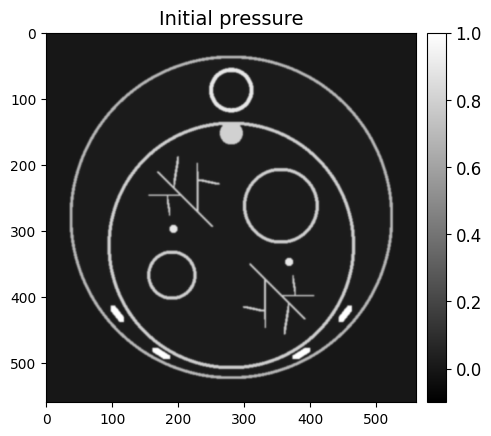

In [4]:
plt.figure(figsize=(9, 9))
norm = Normalize(vmax=0.0, vmin=1.0)
fig, ax = plt.subplots()
plt.title('Initial pressure', fontsize=14)
plt.imshow(IP, norm=norm, cmap='gray')
cax = fig.add_axes([ax.get_position().x1+0.017, ax.get_position().y0, 0.03, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm)
cb.ax.tick_params(labelsize=13)
cb.ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.tick_params(labelsize=12)

Save the initial pressure image.

In [5]:
save_mat(os.path.join(data_path, 'IP.mat'), IP.swapaxes(0,1), 'IP')

Successfully saved data to "../data/IP.mat".


### Speed of Sound

Now we simulate the speed of sound distribution. The structures in the SOS match the initial pressure image, and the SOS values are picked according to [experimentally measured data](https://itis.swiss/virtual-population/tissue-properties/database/acoustic-properties/speed-of-sound/).

The SOS in water is a polynomial function of temperature. The parameters we used are measure in [this paper](https://doi.org/10.1121/1.420332).

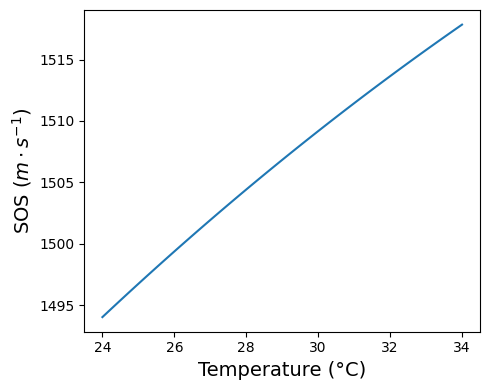

In [6]:
ts = np.linspace(24, 34, 100)
vs = [get_water_SOS(t) for t in ts]
plt.figure(figsize=(5, 4))
plt.plot(ts, vs)
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('SOS ($m \cdot s^{-1}$)', fontsize=14)
plt.xlim(23.5, 34.5)
plt.tight_layout()

In [7]:
T = 26.0
v0 = get_water_SOS(T)   # SOS of the two circles. [m/s]
structures = {
    'body': (9.8e-3, 1545, 1027, (0, 0)),
    'liver': (7.5e-3, 1585.7, 1079, (0, 1.7e-3)),
    'vertebral column': (1.35e-3, 2500, 1908, (0, -7.7e-3)),
    'spinal cord': (1.1e-3, 1542.0, 1075, (0, -7.7e-3)),
    'abdominal aorta': (0.7e-3, 1578.2, 1050, (0, -5.1e-3)), 
    'stomach lumen': (2.3e-3, 1510, 1, (3e-3, -0.7e-3)),
    'bone': (1.5e-3, 2500, 1908, (-3.6e-3, 3.5e-3)),
}

structures_error = {
    'body': (9.8e-3, 1550, 1027, (0, 0)),
    'liver': (7.5e-3, 1575, 1079, (0, 1.7e-3)),
    'vertebral column': (1.35e-3, 1900, 1908, (0, -7.7e-3)),
    'spinal cord': (1.1e-3, 1542.0, 1075, (0, -7.7e-3)),
    'abdominal aorta': (0.7e-3, 1570, 1050, (0, -5.1e-3)), 
    'stomach lumen': (2.3e-3, 1525, 1, (3e-3, -0.7e-3)),
    'bone': (1.5e-3, 1900, 1908, (-3.6e-3, 3.5e-3)),
}

structures_easy = {
    'body': (9.8e-3, 1545, 1027, (0, 0)),
    'liver': (7.5e-3, 1575, 1079, (0, 1.7e-3)),
    'vertebral column': (1.35e-3, 1650, 1908, (0, -7.7e-3)),
    'spinal cord': (1.1e-3, 1542.0, 1075, (0, -7.7e-3)),
    'abdominal aorta': (0.7e-3, 1578, 1050, (0, -5.1e-3)), 
    'stomach lumen': (2.3e-3, 1510, 1, (3e-3, -0.7e-3)),
    'bone': (1.5e-3, 1650, 1908, (-3.6e-3, 3.5e-3)),
}

Complete SOS used in numerical phantom.

In [8]:
SOS = np.ones((Ny, Nx)) * v0
density = np.ones((Ny, Nx)) * 994
for key, (R, v, rou, offset) in structures.items():
    SOS[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = v
    density[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = rou

Easy SOS.

In [9]:
SOS_easy = np.ones((Ny, Nx)) * v0
density = np.ones((Ny, Nx)) * 994
for key, (R, v, rou, offset) in structures_easy.items():
    SOS_easy[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = v
    density[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = rou

SOS with errors.

In [10]:
SOS_error = np.ones((Ny, Nx)) * v0
density = np.ones((Ny, Nx)) * 994
for key, (R, v, rou, offset) in structures_error.items():
    SOS_error[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = v
    density[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = rou

Body only.

In [11]:
SOS_body = np.ones((Ny, Nx)) * v0
for key in ['body']:
    (R, v, rou, offset) = structures[key]
    SOS_body[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = v

Body + liver.

In [12]:
SOS_body_liver = np.ones((Ny, Nx)) * v0
for key in ['body', 'liver']:
    (R, v, rou, offset) = structures_easy[key]
    SOS_body_liver[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = v # Draw ring.

Single-body SOS.

In [13]:
average_SOS = np.mean(SOS_easy[x_vec**2 + y_vec**2 < (9.8e-3)**2])
print(v0, average_SOS)

SOS_SB = np.ones((Ny, Nx)) * v0
SOS_SB[x_vec**2 + y_vec**2 < (9.8e-3)**2] = average_SOS

1499.3632858457756 1561.4044890187697


Uniform SOS.

In [14]:
SOS_uniform = np.ones((Ny, Nx)) * v0

Visualize all SOS distributions.

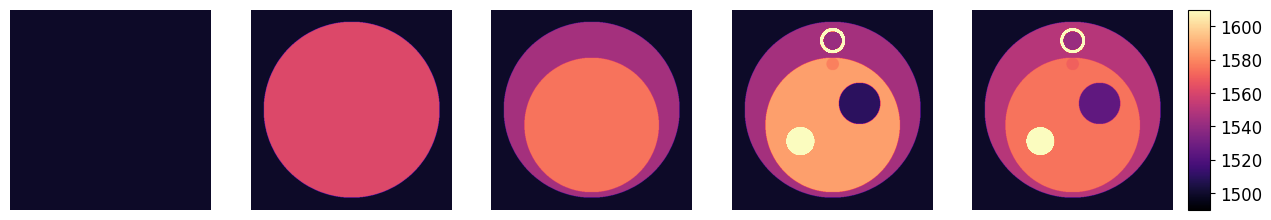

In [15]:
fig = plt.figure(figsize=(15, 6))
norm = Normalize(vmax=1610, vmin=1490)
for idx, SOS in enumerate([SOS_uniform, SOS_SB, SOS_body_liver, SOS, SOS_error]):
    ax = plt.subplot(1,5,idx+1)
    # plt.title('Single-body Speed of Sound Distribution', fontsize=14)
    plt.imshow(SOS, norm=norm, cmap='magma')
    plt.axis('off')
    if idx == 4:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.015, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm)
        # cb.ax.set_yticks([1500, 1520, 1540, 1560, 1580, 1600], [])
        cb.ax.tick_params(labelsize=12)

Save the SOS distributions for simulations and the SOS figure.

In [16]:
save_mat(os.path.join(data_path, 'density.mat'), density.swapaxes(0,1), 'density')
save_mat(os.path.join(data_path, 'SOS.mat'), SOS.swapaxes(0,1), 'SOS')
save_mat(os.path.join(data_path, 'SOS_easy.mat'), SOS_easy.swapaxes(0,1), 'SOS')
save_mat(os.path.join(data_path, 'SOS_error.mat'), SOS_error.swapaxes(0,1), 'SOS')
save_mat(os.path.join(data_path, 'SOS_SB.mat'), SOS_SB.swapaxes(0,1), 'SOS')
save_mat(os.path.join(data_path, 'SOS_body.mat'), SOS_body.swapaxes(0,1), 'SOS')
save_mat(os.path.join(data_path, 'SOS_body_liver.mat'), SOS_body_liver.swapaxes(0,1), 'SOS')
save_mat(os.path.join(data_path, 'SOS_uniform.mat'), SOS_uniform.swapaxes(0,1), 'SOS')

Successfully saved data to "../data/density.mat".
Successfully saved data to "../data/SOS.mat".
Successfully saved data to "../data/SOS_easy.mat".
Successfully saved data to "../data/SOS_error.mat".
Successfully saved data to "../data/SOS_SB.mat".
Successfully saved data to "../data/SOS_body.mat".
Successfully saved data to "../data/SOS_body_liver.mat".
Successfully saved data to "../data/SOS_uniform.mat".
